In [5]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# Psychometric Curve

## Import Libraries

In [6]:
import numpy as np
import pandas as pd
import os, requests
from matplotlib import pyplot as plt

import matplotlib.cm as cm
colormap = cm.viridis

## Import plot functions and define parameters

In [7]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load data

In [8]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [9]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# hide_toggle()

## Select session and group brain regions

Function: dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

In [10]:
def load_data(n_session):
    dat = alldat[n_session]

    # groupings of brain regions
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                    ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                    ]

    nareas = 4 # only the top 4 regions are in this particular mouse
    NN = len(dat['brain_area']) # number of neurons
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
        
    return dat, barea, NN, regions, brain_groups, nareas

n_session = 8
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
hide_toggle()

## Define functions: contrast difference & total contrast

Function: dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(n_session)

In [11]:
def get_task_difference(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']         # contrast left
    r_cont = dat['contrast_right']        # contrast right
    
    cont_diff = l_cont - r_cont   # contrast difference
    abs_task_diff = np.abs(l_cont - r_cont)   # absolute contrast difference
    dtask_diff = np.diff(abs_task_diff)       # change in contrast difference (current - previous)
#     print(np.unique(dtask_diff))
    dtdiff = np.insert(dtask_diff, 0, 0)  # adjust the array size
#     print(dtdiff.shape)

    return dt, NT, cont_diff, abs_task_diff, dtask_diff, dtdiff

# dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(1)
hide_toggle()

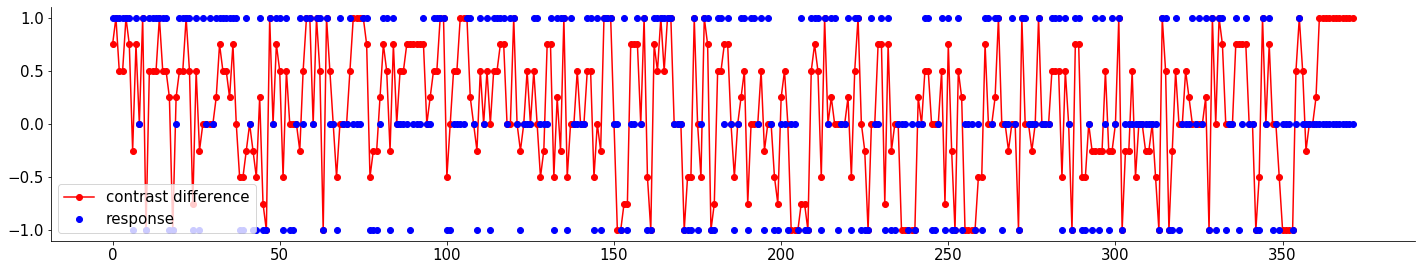

In [12]:
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
plt.plot(cont_diff,'ro-', label='contrast difference')
plt.plot(dat['response'],'bo', label='response')
plt.legend()
plt.show()

In [13]:
print(len(cont_diff))
unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences
dict(zip(unique,counts))

372


{-1.0: 35,
 -0.75: 11,
 -0.5: 28,
 -0.25: 31,
 0.0: 96,
 0.25: 19,
 0.5: 60,
 0.75: 40,
 1.0: 52}

In [14]:
print('session: ', n_session)
print('contrast difference:', np.unique(cont_diff)[-1],' occurence:', counts[-1])
resp = (dat['response'][cont_diff==1])
# np.sum(resp)
# np.count_nonzero(resp==1)
# resp.shape

session:  8
contrast difference: 1.0  occurence: 52


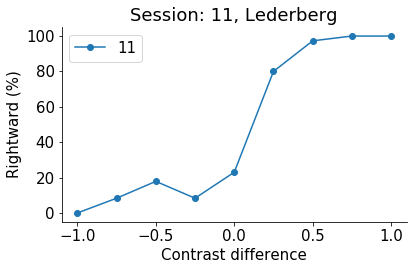

In [15]:
def get_rightward(dat, cont_diff):
    """
    Inputs: 
        * dat - data 
        * cont_diff - contrast difference between left and right
    Return:
        * rightward - % of mice respond right for each contrast difference
    """
    rightward = np.zeros(len(np.unique(cont_diff)))
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    for i, val in enumerate(np.unique(cont_diff)):
        resp = dat['response'][cont_diff==val]
        rightward[i] = np.count_nonzero(resp==1) / counts[i]*100
        
    return rightward

# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
rightward = get_rightward(dat, cont_diff)

# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(np.unique(cont_diff),rightward,'o-', label=n_session)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend()
plt.show()

### 39 Sessions

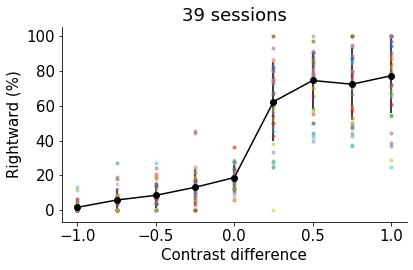

In [16]:
fig = plt.figure(figsize=(6,4))

# ========== Select session number ==========
rt_data = np.zeros((39,9))

for n_session in range(39):
    dat, _, _, _, _, _ = load_data(n_session)
    _, _, cont_diff, _, _, _ = get_task_difference(n_session)
    rightward = get_rightward(dat, cont_diff)
    rt_data[n_session,:]=rightward
    # ========== Plot ==========
    plt.plot(np.unique(cont_diff),rightward,'.', label=n_session, alpha=0.4)

# ========== Comput and plot mean and variance ==========
rt_mean = np.zeros(9)
for i in range(9):
    rt_mean[i] = np.mean(rt_data[:,i])
#     print(np.std(rt_data[:,i]))
    plt.errorbar(np.unique(cont_diff)[i], np.mean(rt_data[:,i]), np.std(rt_data[:,i]), fmt='-ko')
plt.plot(np.unique(cont_diff), rt_mean, 'k-', alpha=1)
plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('39 sessions')
# plt.legend()
plt.show()

## History Dependence

In [17]:
def get_right_hist(dat, cont_diff):
    """
    Inputs: 
        * dat - trial data 
        * cont_diff - contrast difference between left and right
    Return:
        * reasy_l - % of mice respond right for each contrast difference, previous trial is easy left
        * rdiff_l - % of mice respond right for each contrast difference, previous trial is difficult left
        * reasy_r - % of mice respond right for each contrast difference, previous trial is easy right
        * rdiff_r - % of mice respond right for each contrast difference, previous trial is difficult right
    """
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    n_el = n_dl = n_er = n_dr = n_zero = 0

    # Define easy/difficult left/right (boolean array)
    easy_l = (cont_diff==-1) + (cont_diff==-0.75)
    diff_l = (cont_diff==-0.5) + (cont_diff==-0.25)
    diff_r = (cont_diff==0.25) + (cont_diff==0.5)
    easy_r = (cont_diff==0.75) + (cont_diff==1)

    reasy_l = np.zeros((easy_l.sum(),9,2)) # 59 x 9
    rdiff_l = np.zeros((diff_l.sum(),9,2)) # 52 x 9
    reasy_r = np.zeros((easy_r.sum(),9,2)) # 41 x 9
    rdiff_r = np.zeros((diff_r.sum(),9,2)) # 62 x 9
    rzero = np.zeros(((cont_diff==0).sum(),9,2)) # 126 x 9

    for i in range(len(dat['response'])-1):
        hist = cont_diff[i]                                  # previous trial difficulty (size) & direction (sign)
        idx_cont = np.where(unique==cont_diff[i+1])[0][0]   # current trial difficulty and direction label (9 unique labels)

        if hist in unique[0:2]: # easy left
            reasy_l[n_el, idx_cont,0] = dat['response'][i+1]
            reasy_l[0,idx_cont,1] +=1
            n_el += 1
        elif hist in unique[2:4]: # difficult left
            rdiff_l[n_dl, idx_cont,0] = dat['response'][i+1]
            rdiff_l[0, idx_cont,1] += 1
            n_dl += 1
        elif hist in unique[5:7]: # difficult right
            rdiff_r[n_dr, idx_cont,0] = dat['response'][i+1]
            rdiff_r[0, idx_cont,1] += 1
            n_dr += 1
        elif hist in unique[7:9]: # easy right
            reasy_r[n_er, idx_cont,0] = dat['response'][i+1]
            reasy_r[0, idx_cont,1] += 1
            n_er += 1
        elif hist == 0:
            rzero[n_zero, idx_cont,0] = dat['response'][i+1]
            rzero[0, idx_cont,1] += 1
            n_zero += 1
        else:
            print('Check: something is wrong')

    # Use np.divide(a, b, out=np.zeros(a.shape), where=b!=0) to avoid 0 division error
    r_easyr = np.divide(np.count_nonzero(reasy_r[:,:,0]==1,axis=0),
                        reasy_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_r[:,:,0]==1,axis=0).shape), 
                        where=(reasy_r[0,:,1]!=0)) * 100
    r_easyl = np.divide(np.count_nonzero(reasy_l[:,:,0]==1,axis=0),
                        reasy_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_l[:,:,0]==1,axis=0).shape), 
                        where=(reasy_l[0,:,1]!=0)) * 100
    r_diffr = np.divide(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0),
                        rdiff_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_r[0,:,1]!=0)) * 100
    r_diffl = np.divide(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0),
                        rdiff_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_l[0,:,1]!=0)) * 100
    r_zero = np.divide(np.count_nonzero(rzero[:,:,0]==1,axis=0),
                       rzero[0,:,1], 
                       out=np.zeros(np.count_nonzero(rzero[:,:,0]==1,axis=0).shape), 
                       where=(rzero[0,:,1]!=0)) * 100
        
    return r_easyr, r_easyl, r_diffr, r_diffl, r_zero

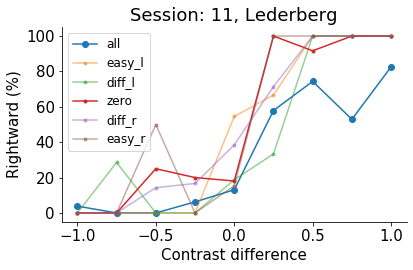

In [18]:
# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
r_easyr, r_easyl, r_diffr, r_diffl, r_zero = get_right_hist(dat, cont_diff)
# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(np.unique(cont_diff),rightward,'o-', label='all')
plt.plot(np.unique(cont_diff),r_easyl,'.-', label='easy_l', alpha=0.5)
plt.plot(np.unique(cont_diff),r_diffl,'.-', label='diff_l', alpha=0.5)
plt.plot(np.unique(cont_diff),r_zero,'.-', label='zero')
plt.plot(np.unique(cont_diff),r_diffr,'.-', label='diff_r', alpha=0.5)
plt.plot(np.unique(cont_diff),r_easyr,'.-', label='easy_r', alpha=0.5)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend(fontsize=12)
plt.show()

# Convergent Cross Mapping

In [19]:
import numpy as np
from sklearn import neighbors
from sklearn import metrics
import pandas as pd
import time




class CCM:
    """Convergent cross mapping for two embedded time series.
    Parameters
    ----------
    weights : str
        Weighting scheme for predictions. Options:
        - 'exp' : exponential weighting
    score : str
        How to score the predictions. Options:
        - 'score'
        - 'corrcoef'
    verbose : bool
        Prints out calculation status.
    """

    def __init__(self, weights='exp', verbose=False):

        self.weights = weights
        self.verbose = verbose


    def fit(self, X1_train, X2_train):
        """Fit the training data for ccm. Can be thought of as reconstructing the
        shadow manifolds of each time series.
        Amount of near neighbors is set to be embedding dimension plus one.
        Creates seperate near neighbor regressors for X1 and X2 independently.
        Parameters
        ----------
        X1_train : 2d array
            Embed time series of shape (num_samps,embed_dim).
        X2_train : 2d array
            Embed time series of shape (num_samps,embed_dim).
        """

        # Save X1_train and X2_train for prediction later. Confusing,
        # but we need to make predictions about our testing set using these.
        self.X1_train = X1_train
        self.X2_train = X2_train

        #to sorround a point, there must be ndim + 1 points
        near_neighs = X1_train.shape[1] + 1

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs)
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs)

    def predict(self, X1_test, X2_test, lib_lengths):
        """Make a prediction.
        Parameters
        ----------
        X1_test : 2d array
            Embed time series of shape (num_samps,embed_dim).
        X2_test : 2d array
            Embed time series of shape (num_samps,embed_dim).
        lib_lengths : 1d array of ints
            Library lengths to test.
        Returns
        -------
        X1_pred : list of 2d arrays
            Predictions for each library length.
        X2_pred : list of 2d arrays
            Predictions for each library length.
        """

        #store X1_test and X2_test for use later
        self.X1_test = X1_test
        self.X2_test = X2_test

        X1_pred = []
        X2_pred = []


        for liblen in lib_lengths:

            x1_p = np.empty(X1_test.shape)
            x2_p = np.empty(X2_test.shape)

            #keep only the indices that are less than library length
            self.knn1.fit(self.X1_train[:liblen], self.X1_train[:liblen])
            self.knn2.fit(self.X2_train[:liblen], self.X2_train[:liblen])

            dist1,ind1 = self.knn1.kneighbors(X1_test)
            dist2,ind2 = self.knn2.kneighbors(X2_test)


            for j in range(self.X1_train.shape[1]):

                W1 = utilities.exp_weight(dist1)
                W2 = utilities.exp_weight(dist2)

                #flip the weights and indices
                x1_p[:, j] = np.sum(self.X1_train[ind2, j] * W2, axis=1)
                x2_p[:, j] = np.sum(self.X2_train[ind1, j] * W1, axis=1)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)

        self.X1_pred = X1_pred
        self.X2_pred = X2_pred

        return X1_pred, X2_pred


    def score(self, score_metric='corrcoef'):
        """Evalulate the predictions.
        Parameters
        ----------
        how : string
            How to score the predictions. Options:
            - 'score'
            - 'corrcoef'
        Returns
        -------
        score_1 : 2d array
            Scores for the first time series using the weights from the second
            time series.
        score_2 : 2d array
            Scores for the second time series using the weights from the first
            time series.
        """

        num_preds = self.X1_train.shape[1]

        score_1 = []
        score_2 = []

        for x1_p, x2_p in zip(self.X1_pred, self.X2_pred):

            sc1 = np.empty(num_preds)
            sc2 = np.empty(num_preds)

            for ii in range(num_preds):

                p1 = x1_p[:,ii]
                p2 = x2_p[:,ii]

                if score_metric == 'score':
                    sc1[ii] = utilities.score(p1,self.X1_test[:,ii])
                    sc2[ii] = utilities.score(p2,self.X2_test[:,ii])

                if score_metric == 'corrcoef':
                    sc1[ii] = utilities.corrcoef(p1,self.X1_test[:,ii])
                    sc2[ii] = utilities.corrcoef(p2,self.X2_test[:,ii])

            score_1.append( np.mean(sc1) )
            score_2.append( np.mean(sc2) )

        return score_1, score_2


class Embed:
    """Embed a time series.
    Parameters
    ----------
    X : 1D array
        Time series to be embed.
    """

    def __init__(self,X):

        if type(X) is pd.pandas.core.frame.DataFrame:
            self.df = X
        else:
            self.X = X


    def df_mutual_information(self, max_lag):
        """Calculates the mutual information along each column of a dataframe.
        Ensure that the time series is continuous in time and sampled regularly.
        You can resample it hourly, daily, minutely etc. if needed.
        Parameters
        ----------
        max_lag : int
        	maximum amount to shift the time series
        Returns
        -------
        mi : dataframe
        	columns are the columns of the original dataframe with rows being
        	the mutual information. shape(max_lag,num_cols)
        """

        cols = self.df.columns
        mi = np.empty((max_lag, len(cols)))

        for i,col in enumerate(cols):

            self.X = self.df[col].values
            mi[:,i] = self.mutual_information(max_lag)

        mi = pd.DataFrame(mi,columns=cols)

        return mi

    def mutual_information(self, max_lag):
        """Calculates the mutual information between the an unshifted time
        series and a shifted time series.
        Utilizes scikit-learn's implementation of the mutual information found
        in sklearn.metrics.
        Parameters
        ----------
        max_lag : integer
            Maximum amount to shift the time series.
        Returns
        -------
        m_score : 1-D array
            Mutual information at between the unshifted time series and the
            shifted time series,
        """

        #number of bins - say ~ 20 pts / bin for joint distribution
        #and that at least 4 bins are required
        N = max(self.X.shape)
        num_bins = max(4.,np.floor(np.sqrt(N/20)))
        num_bins = int(num_bins)

        m_score = np.zeros((max_lag))

        for jj in range(max_lag):
            lag = jj+1

            ts = self.X[0:-lag]
            ts_shift = self.X[lag::]

            min_ts = np.min(self.X)
            max_ts = np.max(self.X)+.0001 #needed to bin them up

            bins = np.linspace(min_ts,max_ts,num_bins+1)

            bin_tracker = np.zeros_like(ts)
            bin_tracker_shift = np.zeros_like(ts_shift)

            for ii in range(num_bins):

                locs = np.logical_and( ts>=bins[ii], ts<bins[ii+1] )
                bin_tracker[locs] = ii

                locs_shift = np.logical_and( ts_shift>=bins[ii], ts_shift<bins[ii+1] )
                bin_tracker_shift[locs_shift]=ii

            m_score[jj] = metrics.mutual_info_score(bin_tracker,bin_tracker_shift)
        return m_score



    def embed_vectors_1d(self, lag, embed):
        """Embeds vectors from a one dimensional time series in m-dimensional
        space.
        Parameters
        ----------
        X : 1d array
            Training or testing set.
        lag : int
            Lag value as calculated from the first minimum of the mutual info.
        embed : int
            Embedding dimension. How many lag values to take.
        predict : int
            Distance to forecast (see example).
        Returns
        -------
        features : 2d array
            Contains all of the embedded vectors. Shape (num_vectors,embed).
        Example
        -------
        >>> X = [0,1,2,3,4,5,6,7,8,9,10]
        em = 3
        lag = 2
        predict=3
        >>> embed_vectors_1d
        features = [[0,2,4], [1,3,5], [2,4,6], [3,5,7]]
        """

        tsize = self.X.shape[0]
        t_iter = tsize-(lag*(embed-1))

        features = np.zeros((t_iter,embed))

        for ii in range(t_iter):

            end_val = ii+lag*(embed-1)+1

            part = self.X[ii : end_val]

            features[ii,:] = part[::lag]

        return features

hide_toggle()

# Example CCM

In [20]:
#https://skccm.readthedocs.io/en/latest/quick-example.html


#look at convergent cross mapping across brain regions
#from .skccm import CCM, Embed
import skccm.data as data
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)

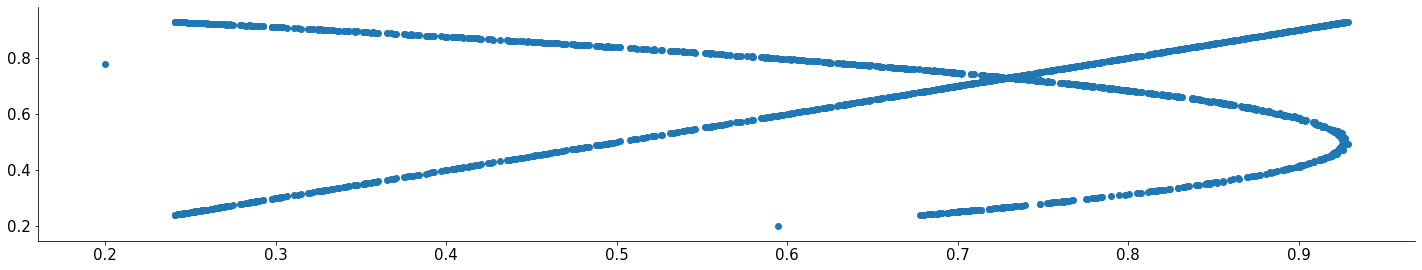

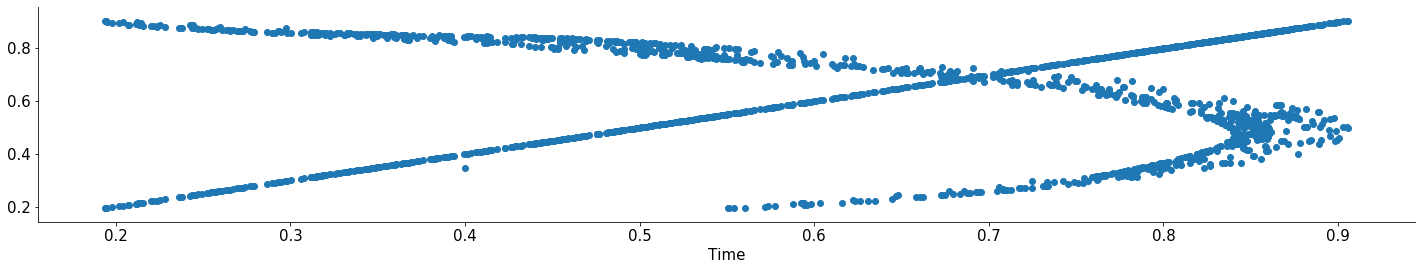

(999,)


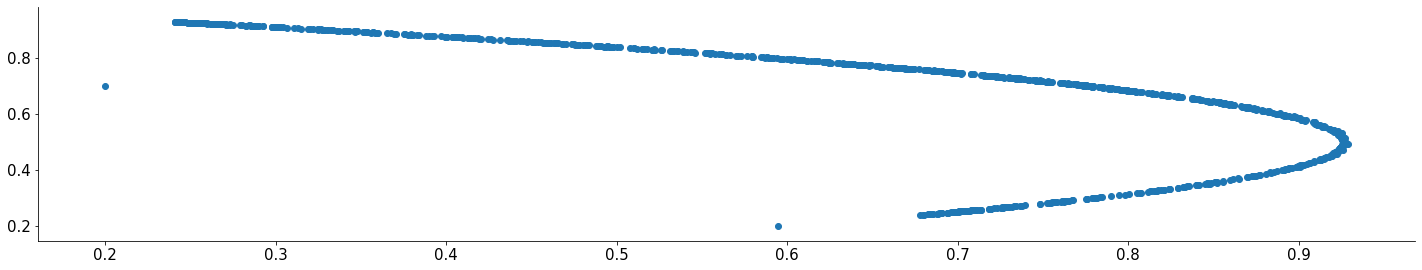

In [99]:
import skccm as ccm
import numpy as np
lag = 1
embed = 2
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

X1_roll = np.roll(X1, 1)
X2_roll = np.roll(X2, 1)

#[list(t) for t in zip(*X1)]

plt.figure(1)
plt.scatter(X1, X1_roll)
#plt.title('Linear Regression Weights Across Features for Hippocampus Session 11')
#plt.xlabel('Feature change in Weights')
#plt.ylabel('Weights')


plt.figure(2)
plt.scatter(X2, X2_roll)
#plt.title('Linear Regression Weights Across Features for Hippocampus Session 11')
plt.xlabel('Time')
#plt.ylabel('Weights')
plt.show()

X1_p = X1[:,0]
print(X1_p.shape)
X1_p_roll = np.roll(X1_p, 1)

plt.figure(3)
plt.scatter(X1_p, X1_p_roll)

ValueError: x and y can be no greater than 2-D, but have shapes (20,) and (20, 250, 2)

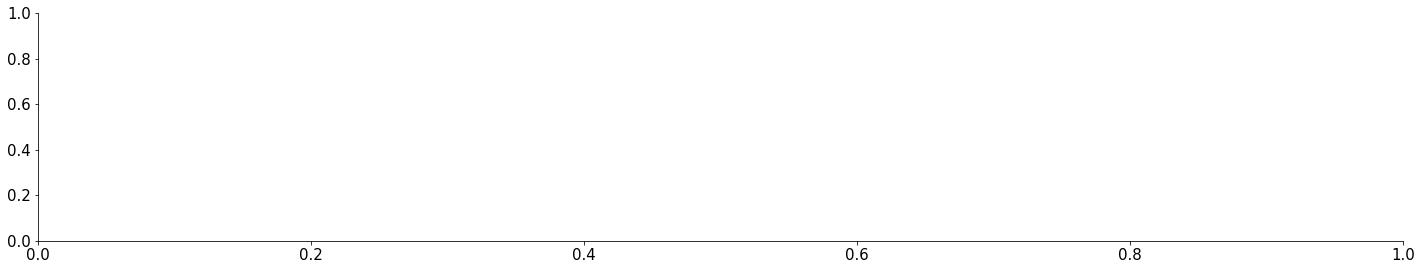

In [81]:
from skccm.utilities import train_test_split
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)
CCM = ccm.CCM() #initiate the class
#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
sc1,sc2 = CCM.score()

plt.plot(x1p)
#plt.plot(sc2)
plt.show()

# CCM Steinmetz Data

In [23]:
#Not sure if this is the correct approach
def get_right_neuronal_response(dat, cont_diff):
    """
    Inputs: 
        * dat - trial data 
        * cont_diff - contrast difference between left and right
    Return:
        * reasy_l - % of mice respond right for each contrast difference, previous trial is easy left
        * rdiff_l - % of mice respond right for each contrast difference, previous trial is difficult left
        * reasy_r - % of mice respond right for each contrast difference, previous trial is easy right
        * rdiff_r - % of mice respond right for each contrast difference, previous trial is difficult right
    """
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    n_el = n_dl = n_er = n_dr = n_zero = 0

    # Define easy/difficult left/right (boolean array)
    easy_l = (cont_diff==-1) + (cont_diff==-0.75)
    diff_l = (cont_diff==-0.5) + (cont_diff==-0.25)
    diff_r = (cont_diff==0.25) + (cont_diff==0.5)
    easy_r = (cont_diff==0.75) + (cont_diff==1)

    reasy_l_neuronal = np.zeros((easy_l.sum(),9,2)) # 59 x 9
    rdiff_l_neuronal = np.zeros((diff_l.sum(),9,2)) # 52 x 9
    reasy_r_neuronal = np.zeros((easy_r.sum(),9,2)) # 41 x 9
    rdiff_r_neuronal = np.zeros((diff_r.sum(),9,2)) # 62 x 9
    rzero_neuronal = np.zeros(((cont_diff==0).sum(),9,2)) # 126 x 9

    for i in range(len(dat['response'])-1):
        hist = cont_diff[i]                                  # previous trial difficulty (size) & direction (sign)
        idx_cont = np.where(unique==cont_diff[i+1])[0][0]   # current trial difficulty and direction label (9 unique labels)

        if hist in unique[0:2]: # easy left
            reasy_l[n_el, idx_cont,0] = dat['response'][i+1]
            reasy_l[0,idx_cont,1] +=1
            n_el += 1
        elif hist in unique[2:4]: # difficult left
            rdiff_l[n_dl, idx_cont,0] = dat['response'][i+1]
            rdiff_l[0, idx_cont,1] += 1
            n_dl += 1
        elif hist in unique[5:7]: # difficult right
            rdiff_r[n_dr, idx_cont,0] = dat['response'][i+1]
            rdiff_r[0, idx_cont,1] += 1
            n_dr += 1
        elif hist in unique[7:9]: # easy right
            reasy_r[n_er, idx_cont,0] = dat['response'][i+1]
            reasy_r[0, idx_cont,1] += 1
            n_er += 1
        elif hist == 0:
            rzero[n_zero, idx_cont,0] = dat['response'][i+1]
            rzero[0, idx_cont,1] += 1
            n_zero += 1
        else:
            print('Check: something is wrong')
        
    return reasy_l_neuronal, rdiff_l_neuronal, reasy_r_neuronal, rdiff_r_neuronal, rzero_neuronal
            
hide_toggle()

In [24]:
# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session)
_, _, cont_diff, _, _, _ = get_right_neuronal_response(n_session)
reasy_l_neuronal, rdiff_l_neuronal, reasy_r_neuronal, rdiff_r_neuronal, rzero_neuronal = get_right_neuronal_response(dat, cont_diff)
# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(np.unique(cont_diff),rightward,'o-', label='all')
plt.plot(np.unique(cont_diff),reasy_l_neuronal,'.-', label='easy_l', alpha=0.5)
plt.plot(np.unique(cont_diff),rdiff_l_neuronal,'.-', label='diff_l', alpha=0.5)
plt.plot(np.unique(cont_diff),rzero_neuronal,'.-', label='zero')
plt.plot(np.unique(cont_diff),rdiff_r_neuronal,'.-', label='diff_r', alpha=0.5)
plt.plot(np.unique(cont_diff),reasy_r_neuronal,'.-', label='easy_r', alpha=0.5)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend(fontsize=12)
plt.show()

TypeError: get_right_neuronal_response() missing 1 required positional argument: 'cont_diff'

In [ ]:
def plot_firing_ctx_means(dat, nareas, dtdiff):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    win_size = 4
    colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtask_diff))))
    
    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j_barea in range(nareas):
        neg_spk = np.zeros(dat['spks'].shape[2])
        pos_spk = np.zeros(dat['spks'].shape[2])

        ax = plt.subplot(2,nareas//2,j_barea+1)

        for i, value in enumerate(np.unique(dtask_diff)):
            plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     label=r'$\Delta$: %1.2f'%value, color=colors[len(np.unique(dtask_diff))-i-1], linewidth=1)
            if value<0:
                neg_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            elif value>0:
                pos_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            else:
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      '--', label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
                value = 0

        neg_sum = pd.Series(1/dt*neg_spk/4).rolling(window=win_size).mean().sum()
        pos_sum = pd.Series(1/dt*pos_spk/4).rolling(window=win_size).mean().sum()
        mean_sum = pd.Series(1/dt*dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/4).rolling(window=win_size).mean(), 'r--',
                 label='neg mean', linewidth=2)
        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/4).rolling(window=win_size).mean(), 'b.-',
                 label='pos mean', linewidth=2)

        plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(), 'k-', 
                label='mean', linewidth=2)

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j_barea), transform=ax.transAxes)

        if j_barea==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=9)

        ax.set(xlabel = 'time (sec) - smoothed. win_size: %1.0f'%win_size, 
               ylabel = r'mean firing rate (Hz)')
        ax.set_title(regions[j_barea])
#                      +r': $\Sigma\bar{f}$=%1.2f'%mean_sum 
#                      +', $\Sigma$-=%1.2f'%neg_sum + '(%1.2f)'%(neg_sum-mean_sum)
#                      +', $\Sigma$+=%1.2f'%pos_sum + '(%1.2f)'%(pos_sum-mean_sum), 
#                      fontsize=12)

    plt.show()

plot_firing_ctx_means(dat, nareas, dtdiff)

In [ ]:
import skccm as ccm
import numpy as np
lag = 1
embed = 2
E1 = ccm.Embed(reasy_r)
E2 = ccm.Embed(rdiff_r)
X1_r_easyr = E1.embed_vectors_1d(lag,embed)
X2_r_diffr = E2.embed_vectors_1d(lag,embed)

plt.figure(1)
plt.plot(X1_r_easyr)
#plt.title('Linear Regression Weights Across Features for Hippocampus Session 11')
#plt.xlabel('Feature change in Weights')
#plt.ylabel('Weights')

plt.figure(2)
plt.plot(X2_r_diffr)
#plt.title('Linear Regression Weights Across Features for Hippocampus Session 11')
#plt.xlabel('Time')
#plt.ylabel('Weights')
plt.show()
print(r_easyr.shape)